In [48]:
from sklearn import svm
import numpy as np
import argparse
import cv2
import os
import random
import skimage.filters as fr
import skimage.io as io
from commonfunctions import *

############################
import joblib
import os.path

# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_splitfrom commonfunctions import *
from matplotlib import pyplot as plt

In [49]:
path_to_dataset = r'dataset_mixed2\dataset_mixed'
target_img_size = (64, 64) # fix image size because classification algorithms THAT WE WILL USE HERE expect that

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

In [50]:
def extract_features(img, feature_set='hog'):
    
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
 #   thr = fr.threshold_otsu(img)
 #   img = np.where(img > thr, 1, 0)
    img = cv2.resize(img, target_img_size)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size_in_cells = (4, 4)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins =4 # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    
    return h.flatten()

In [51]:
def load_dataset(feature_set='hog'):
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'jpg' and fn.split('.')[-1] != 'bmp' :
            continue

        label = fn.split('-')[0]
      #  print(label)
        labels.append(label)

        path = os.path.join(path_to_dataset, fn)
        img = cv2.imread(path)
        features.append(extract_features(img, feature_set))
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(img_filenames)))
 
        
    return features, labels        

In [52]:
classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed)
}

In [53]:
# This function will test all our classifiers on a specific feature set
def run_experiment(feature_set):
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset(feature_set)
#    print(features)
#    print(labels)
    print('Finished loading dataset.')
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        # Train the model only on the training features
        model.fit(train_features, train_labels)
        # save the model to disk
        filename = 'finalized_model.sav'
        joblib.dump(model, filename)
        
        # Test the model on images it hasn't seen before
        accuracy = model.score(test_features, test_labels)
        print(model_name, 'accuracy:', accuracy*100, '%')



model already exit


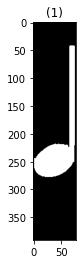

['a_4']


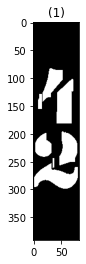

['#']


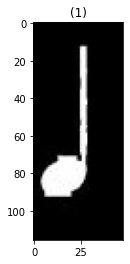

['#']


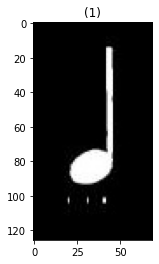

['a_4']


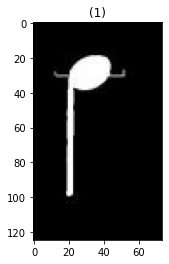

['##']


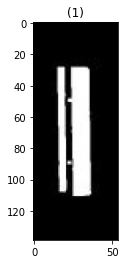

['a_2']


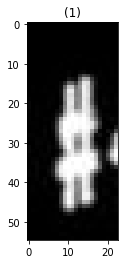

['#']


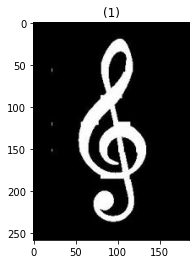

['a_1']


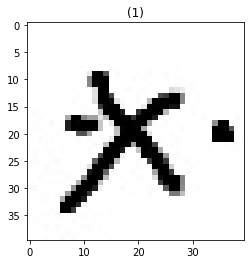

['##']


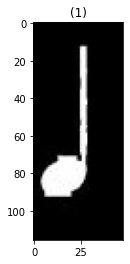

['#']


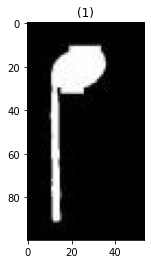

['a_2']


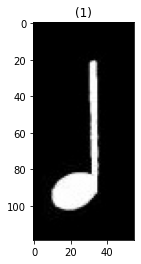

['a_4']


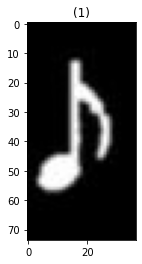

['a_16']


In [57]:
if os.path.isfile('finalized_model.sav'):
    ##### the model already exit####
    print("model already exit")
else:
    ### not exit so train ###
    run_experiment('hog')
    
##########################################    

 # load the model from disk
loaded_model = joblib.load('finalized_model.sav')
    # Example
testpathes=['5-1 (1).png','20-1.png','underdot.jpg','alsounderdot.jpg','alsoupdot.jpg','endsymmbol.jpg','hash.jpg', 'starttotest.jpg', 'test.jpg' ,'underdot.jpg','withupdot.jpg' ,'withdotinbuttom.jpg ','withonflagtest.jpg']
for path in testpathes:
    img = cv2.imread( path )
    show_images([img])
    features = extract_features(img, 'hog')
    print(loaded_model.predict([features]))
    